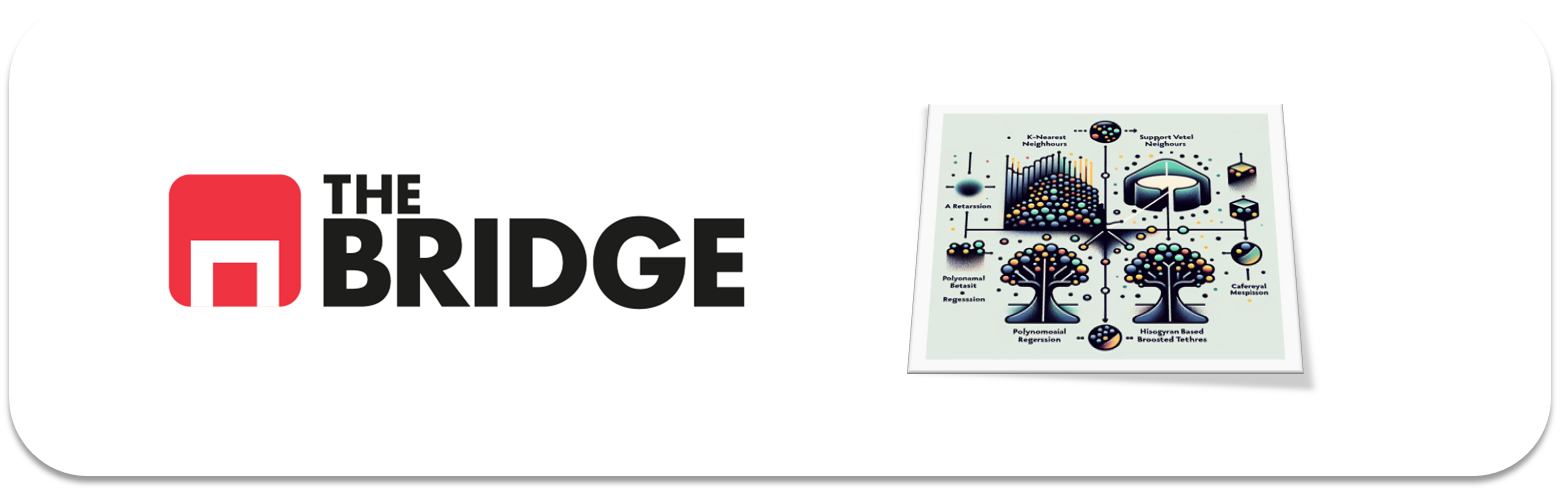

* La práctica consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [42]:
import pandas as pd 
import numpy as np
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos y precision
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error #Regresion
from sklearn.metrics import balanced_accuracy_score #Clasificacion 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB



In [28]:
def apply_onehot_encoder(train:pd.DataFrame, columns_to_encode:list, test:pd.DataFrame=None):
    
    # Resetear índices para evitar desalineación
    train = train.reset_index(drop=True)
    
    # Crear el OneHotEncoder
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Ajustar y transformar las columnas seleccionadas
    transformed_data = encoder.fit_transform(train[columns_to_encode])

    # Crear un DataFrame con las columnas transformadas
    transformed_df = pd.DataFrame(transformed_data, columns=encoder.get_feature_names_out(columns_to_encode))
    
    # Concatenar con el DataFrame original excluyendo las columnas transformadas
    df_concatenated = pd.concat([train.drop(columns_to_encode, axis=1), transformed_df], axis=1)

    # Si se proporciona un segundo DataFrame, aplicar la misma transformación
    if test is not None:
        transformed_data_to_transform = encoder.transform(test[columns_to_encode])
        transformed_df_to_transform = pd.DataFrame(transformed_data_to_transform, columns=encoder.get_feature_names_out(columns_to_encode))
        df_to_transform_concatenated = pd.concat([test.drop(columns_to_encode, axis=1), transformed_df_to_transform], axis=1)
        return df_concatenated, df_to_transform_concatenated

    return df_concatenated

from scipy.stats import norm
def graficar_histograma_y_evaluar_normalidad_visual(df):
    
    columnas_numericas = df.select_dtypes(include=[np.number]).columns

    #Configurar el tamaño de la columna
    num_col = len(columnas_numericas)
    plt.figure(figsize=(15, 5*num_col))

    #Iterar sobre las columnas numericas
    for i, columna in enumerate(columnas_numericas, 1):
        plt.subplot(num_col, 1, i)
        data = df[columna].dropna() #Excluir los NAN de la prueba de normalidad

        #Graficar Histograma y curva Normal
        sns.histplot(data, kde=True, stat='density')
        mu, std = norm.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth = 2)

        #Interpretacion visual
        if p.max() > 0.1: #Un umbral de ejemplo que podrias ajustar
            plt.title(f'{columna} - Distribucion visualmente cercana a la normal')
        else:
            plt.title(f'{columna} - Distribucion visualmente no normal')

    #plt.tigth_layout()
    plt.show


### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

NOTA: El dataset está limpio y sin valores faltantes.

In [4]:
df = pd.read_csv('./datasets/wines_dataset.csv', sep='|')
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.5              0.21         0.26            9.25      0.034   
1               8.3              0.16         0.37            7.90      0.025   
2               6.8              0.18         0.38            1.40      0.038   
3               6.1              0.26         0.25            2.90      0.047   
4               7.5              0.63         0.27            2.00      0.083   
...             ...               ...          ...             ...        ...   
6492            7.7              0.39         0.34           10.00      0.056   
6493            8.2              0.73         0.21            1.70      0.074   
6494            7.4              0.31         0.48           14.20      0.042   
6495            8.3              0.65         0.10            2.90      0.089   
6496            8.4              0.67         0.19            2.20      0.093   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    73.0                 142.0  0.99450  3.05       0.37   
1                    38.0                 107.0  0.99306  2.93       0.37   
2                    35.0                 111.0  0.99180  3.32       0.59   
3                   289.0                 440.0  0.99314  3.44       0.64   
4                    17.0                  91.0  0.99616  3.26       0.58   
...                   ...                   ...      ...   ...        ...   
6492                 35.0                 178.0  0.99740  3.26       0.60   
6493                  5.0                  13.0  0.99680  3.20       0.52   
6494                 62.0                 204.0  0.99830  3.06       0.59   
6495                 17.0                  40.0  0.99803  3.29       0.55   
6496                 11.0                  75.0  0.99736  3.20       0.59   

      alcohol  quality  class  
0        11.4        6  white  
1        11.9        6  white  
2        11.2        7  white  
3        10.5        3  white  
4         9.8        6    red  
...       ...      ...    ...  
6492     10.2        5  white  
6493      9.5        5    red  
6494      9.4        5  white  
6495      9.5        5    red  
6496      9.2        4    red  

[6497 rows x 13 columns]

## Previo 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


No hay duplicados

# Primer Analisis

### EDA

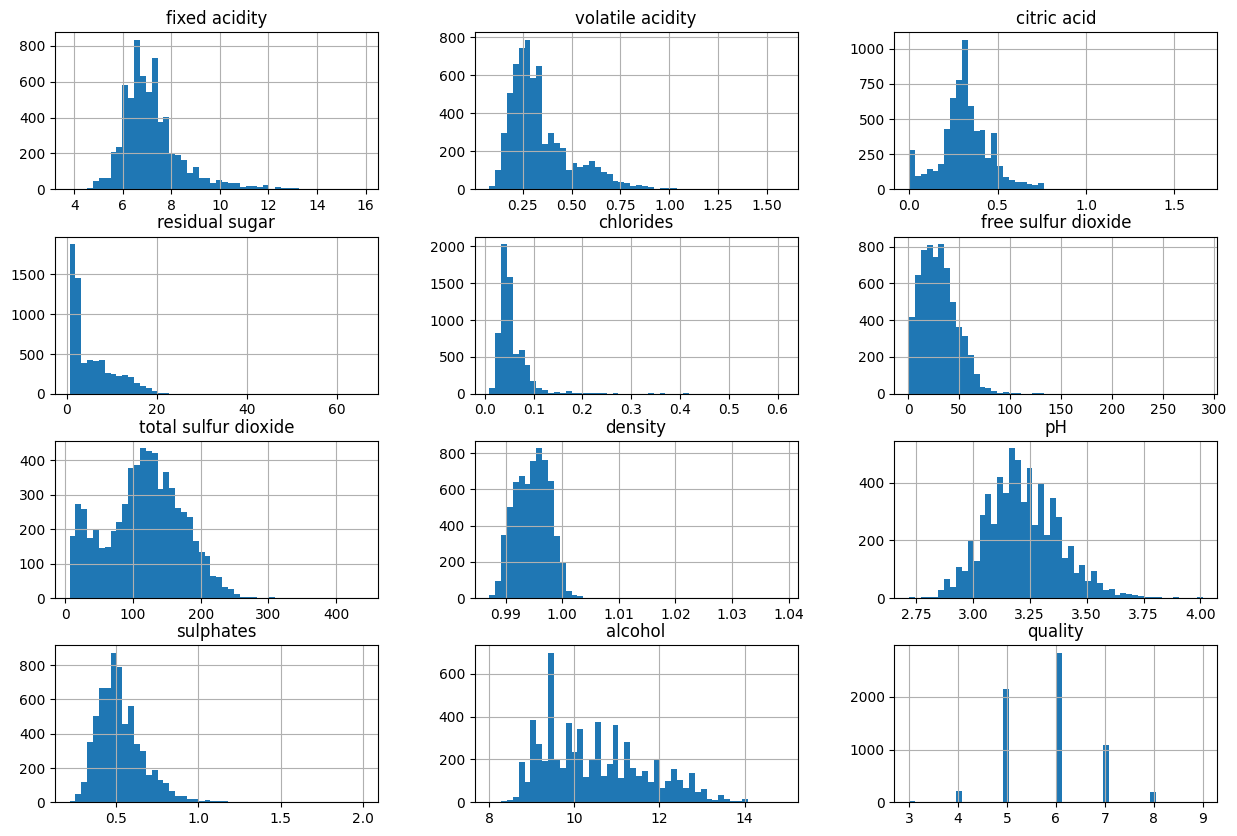

In [6]:
df.hist(bins=50, figsize=(15,10))
plt.show()

In [7]:
import warnings
warnings.filterwarnings('ignore')

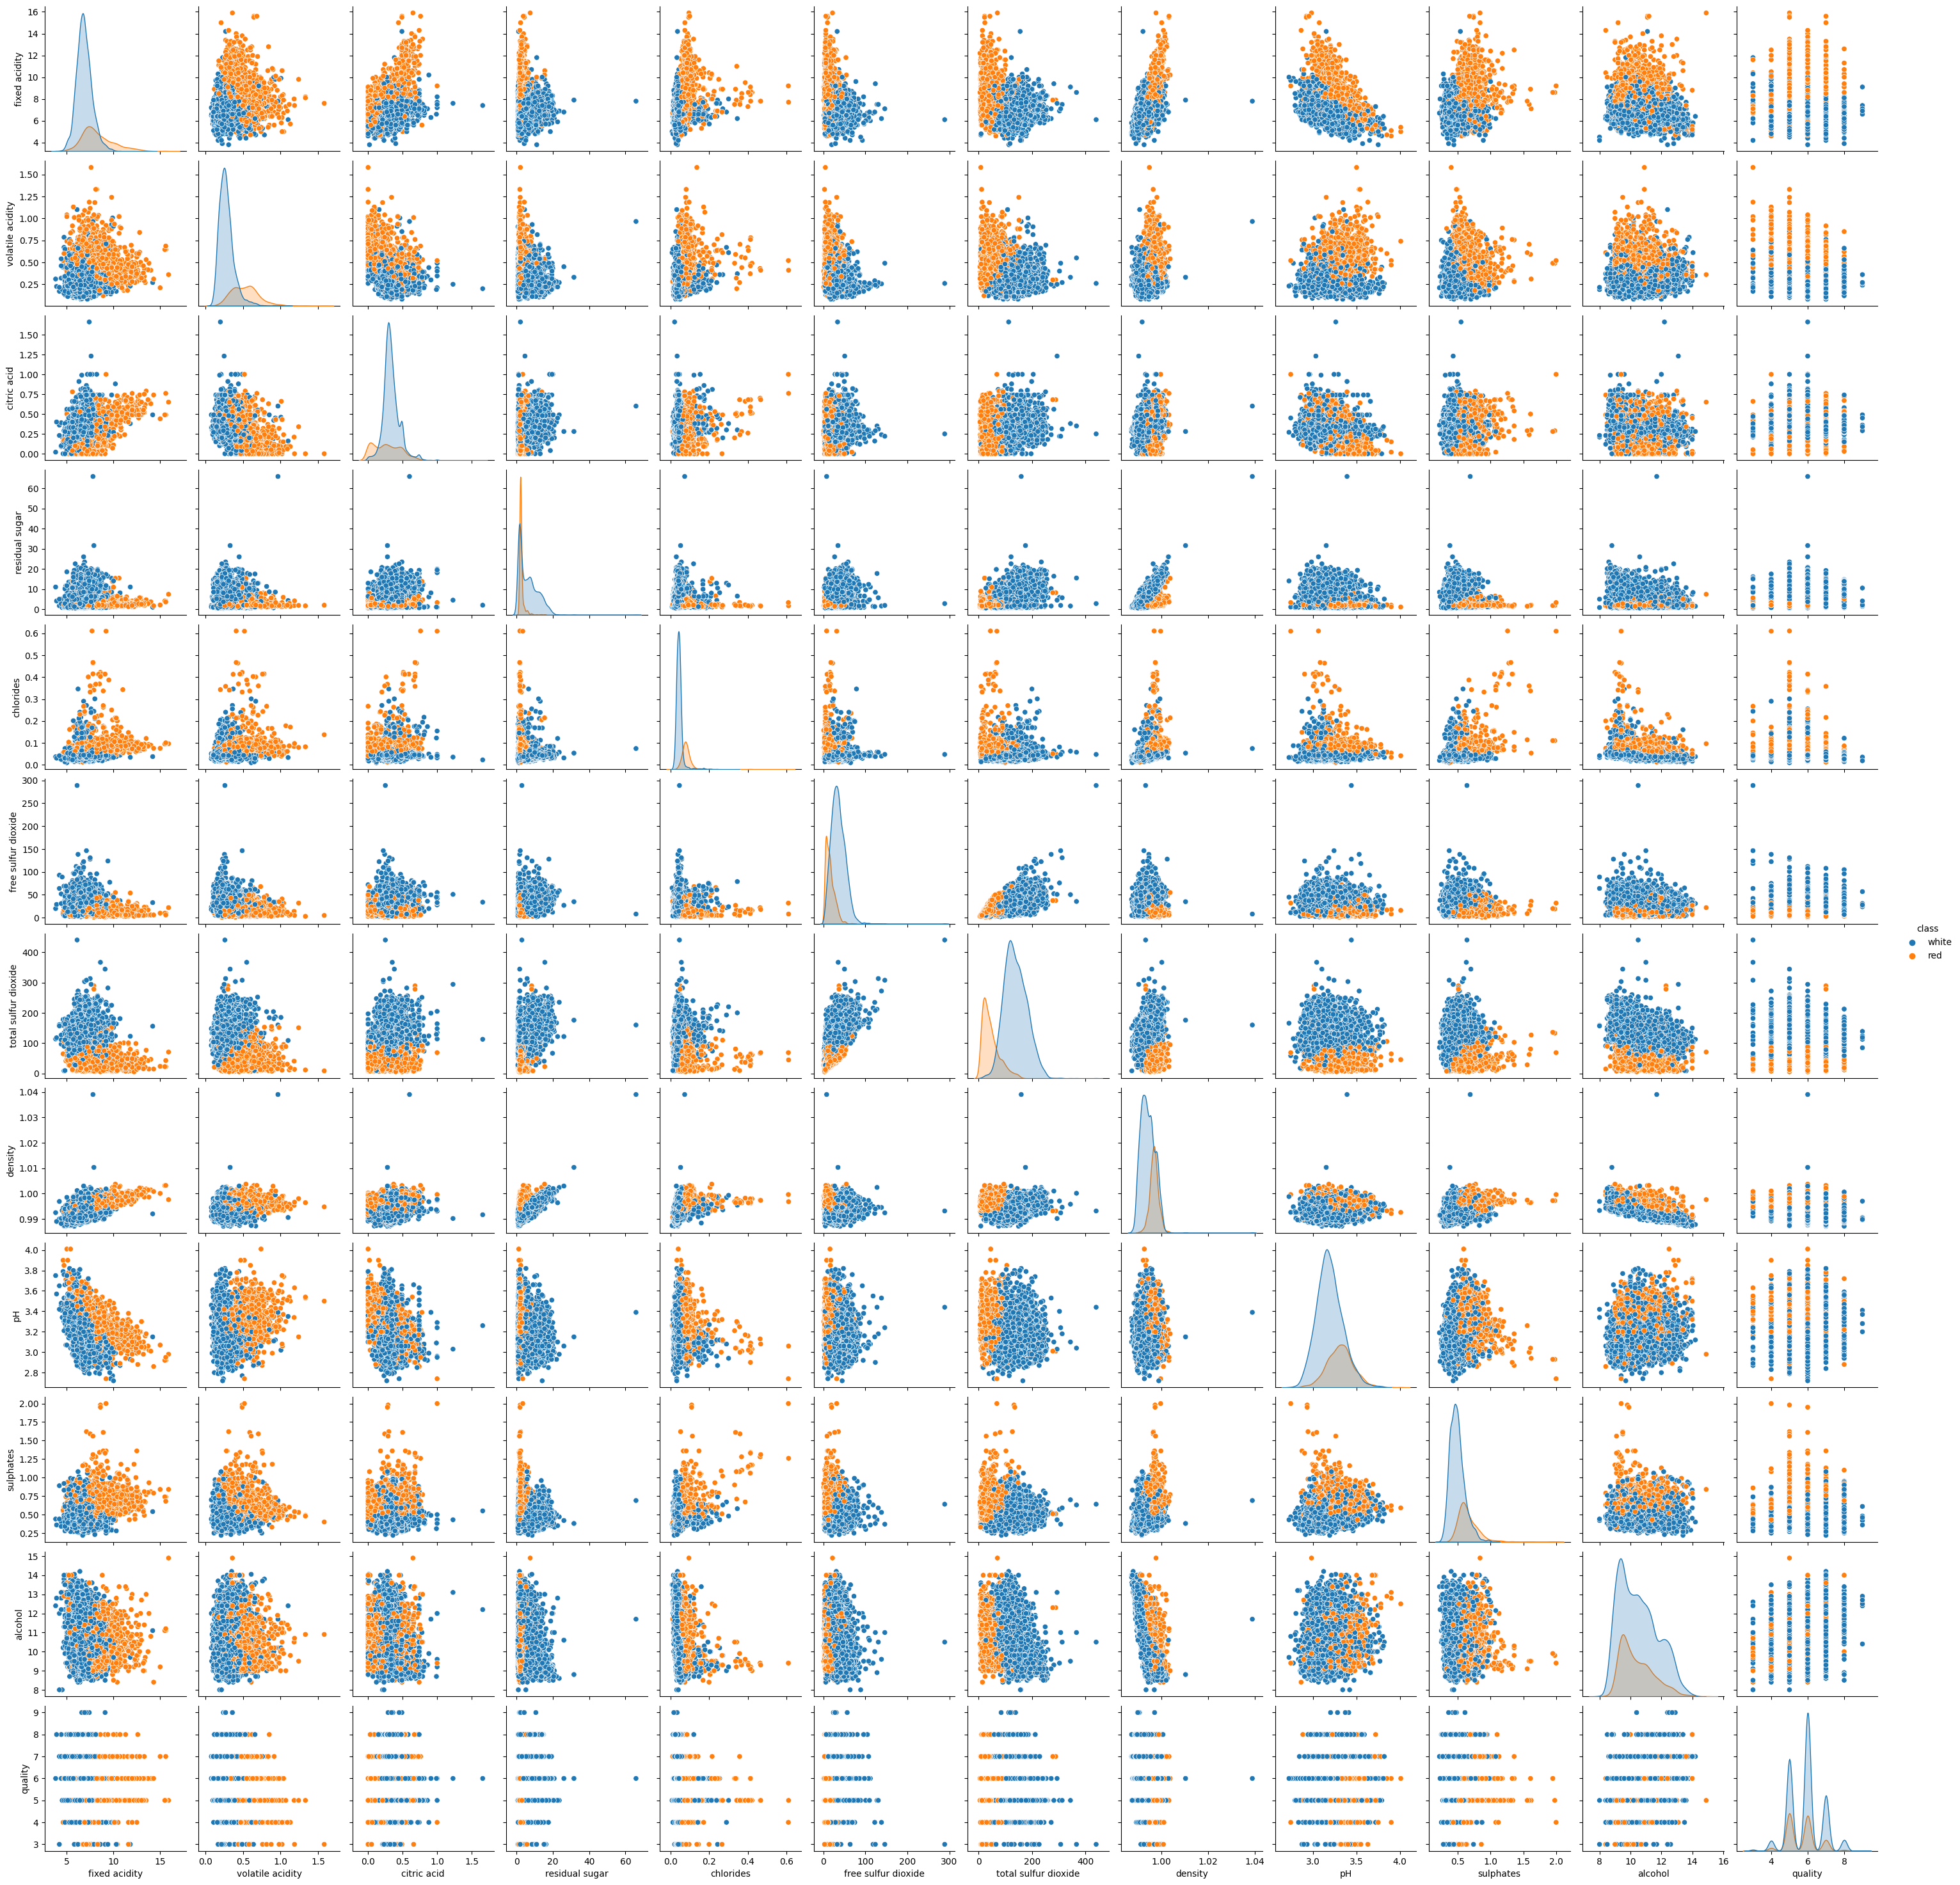

In [8]:
sns.pairplot(df, hue='class')

<Axes: xlabel='quality', ylabel='count'>

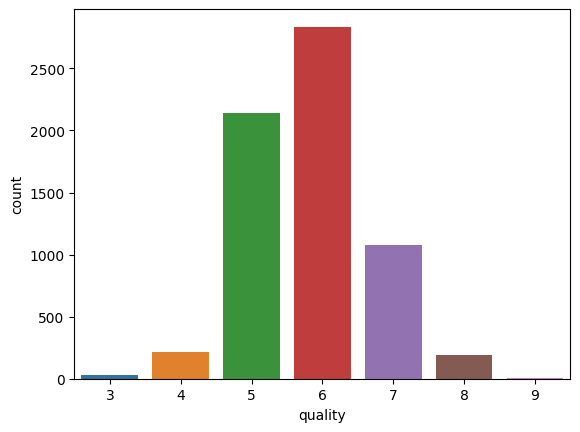

In [9]:
sns.countplot(x='quality', data=df)

In [10]:
df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='count'>

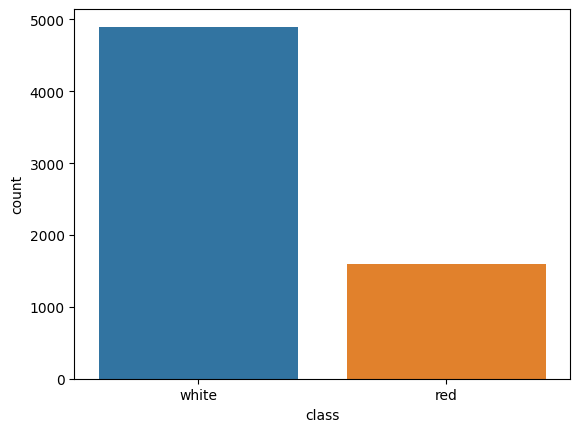

In [11]:
sns.countplot(x='class', data=df)

<Axes: xlabel='class', ylabel='quality'>

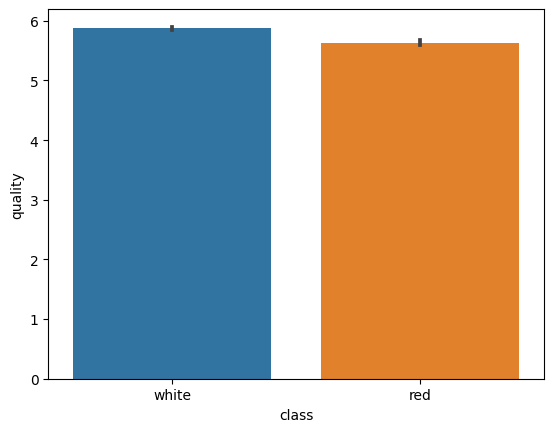

In [12]:
sns.barplot(x='class', y='quality', data=df)

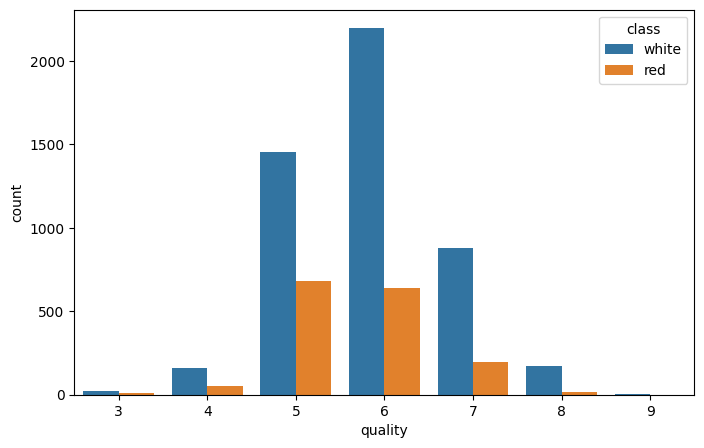

In [29]:
plt.figure(figsize=(8, 5))

sns.countplot(x='quality', hue='class', data=df)
plt.show()

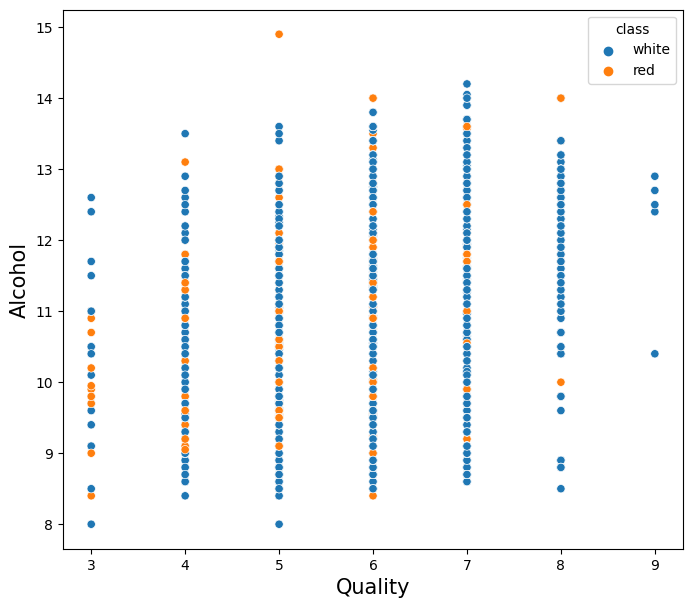

In [30]:
plt.figure(figsize=(8, 7))
sns.scatterplot(x='quality', y='alcohol', hue='class', data=df)
plt.xlabel('Quality', size=15)
plt.ylabel('Alcohol', size=15)
plt.show()

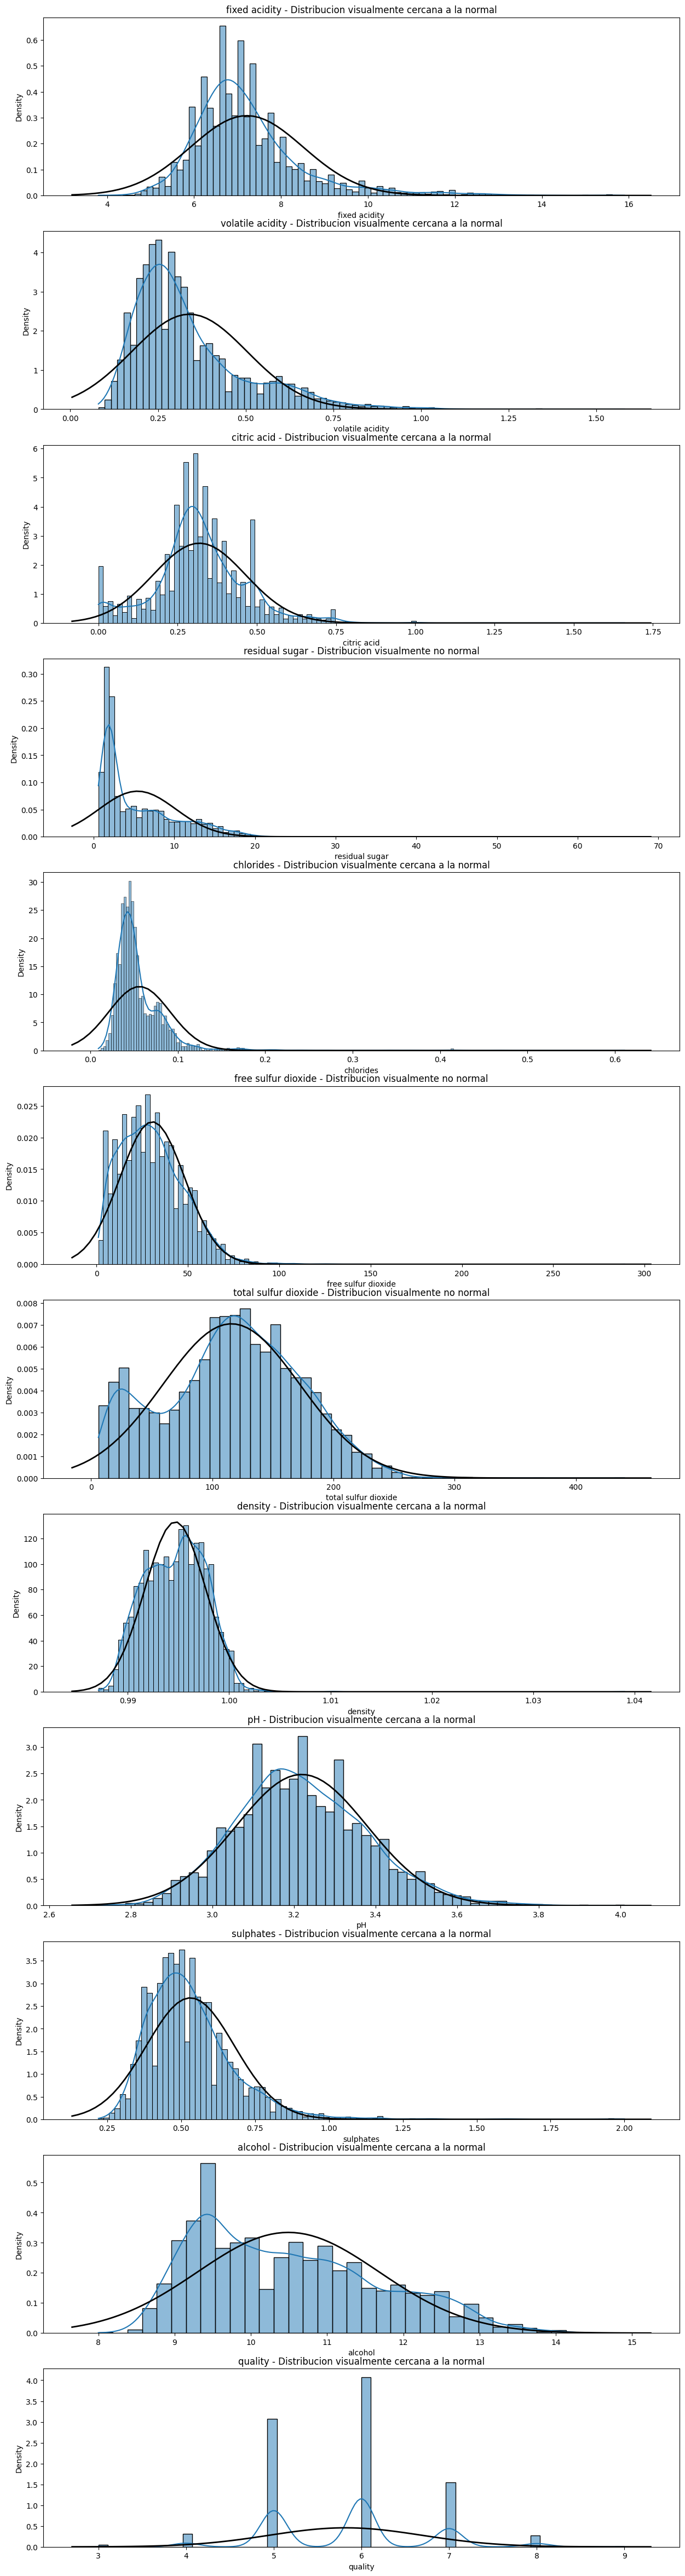

In [27]:
graficar_histograma_y_evaluar_normalidad_visual(df)

Limpieza

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros. El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora.

<Axes: >

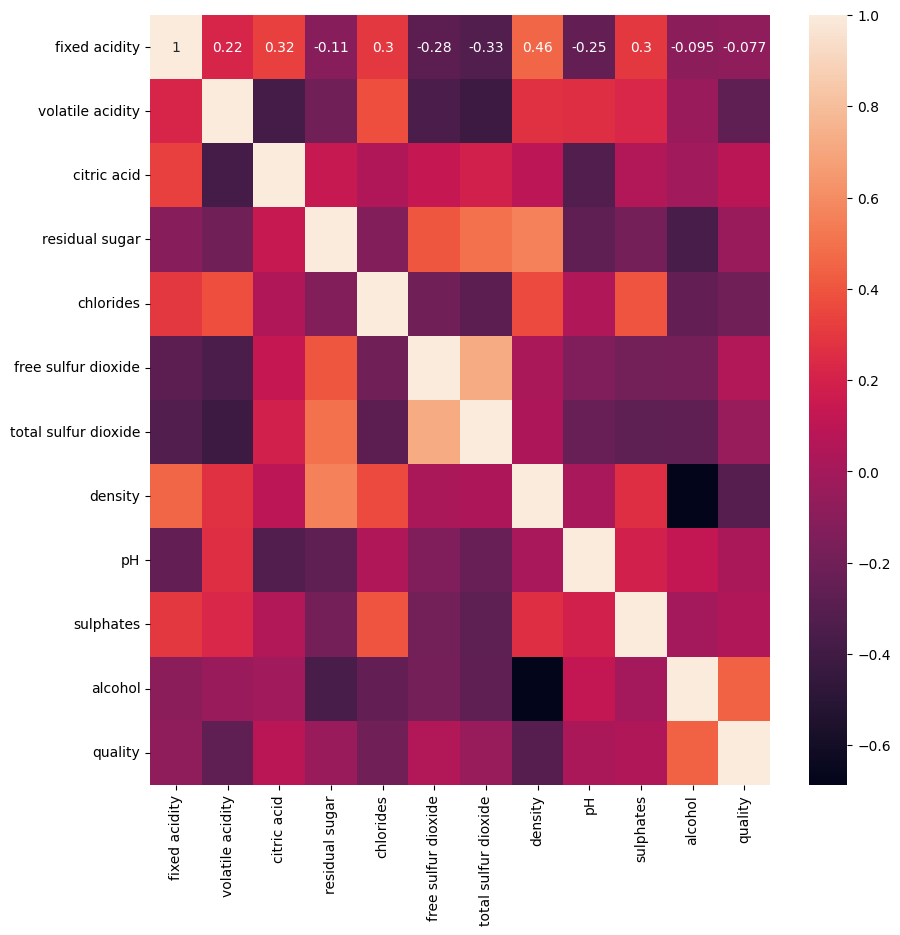

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Tratamos la unica columna no numerica del dataset, se hara un ohe

### Separamos el dataset

In [19]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'class'],
      dtype='object')

In [31]:
df_clasific =df.copy()

In [32]:
X = df_clasific.drop(columns='quality')
y = df_clasific['quality']

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

#Aplicamos logaritmo a las variables, excluimos la variable 'class' (para train y para test)
X_train_log = np.log(X_train.drop(columns='class') + 1) 
X_test_log = np.log(X_test.drop(columns='class') + 1)

#Escalamos las variables del dataset
sca = MinMaxScaler()
sca.fit(X_train_log) #Solo aplicamos .fit a las variables de Train
X_train_log_sca = sca.transform(X_train_log)
X_test_log_sca = sca.transform(X_test_log) #A las variables de Test solo se les aplica el .transform

X_train_log_sca = pd.DataFrame(X_train_log_sca, columns=X_train_log.columns) 
X_test_log_sca = pd.DataFrame(X_test_log_sca, columns=X_test_log.columns)

#Volvemos a asociar la columna 'class' al dataframe 
X_train_log_sca['class'] = X_train['class'] 
X_test_log_sca['class'] = X_test['class']

In [39]:
modelos = [LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),]

In [41]:
# Iterar sobre los modelos y evaluar el rendimiento con diferentes métricas

for modelo in modelos:
    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas de precisión
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')  # Agregar recall macro
    
    # Imprimir el rendimiento del modelo
    print(f'{modelo.__class__.__name__}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print(f'  Recall Macro: {recall_macro:.4f}\n')


LogisticRegression:
  Accuracy: 0.4662
  Precision: 0.3924
  Recall: 0.4662
  F1 Score: 0.3962
  Recall Macro: 0.1957

SVC:
  Accuracy: 0.4331
  Precision: 0.3243
  Recall: 0.4331
  F1 Score: 0.3074
  Recall Macro: 0.1706

DecisionTreeClassifier:
  Accuracy: 0.5785
  Precision: 0.5875
  Recall: 0.5785
  F1 Score: 0.5820
  Recall Macro: 0.3834

RandomForestClassifier:
  Accuracy: 0.6915
  Precision: 0.6947
  Recall: 0.6915
  F1 Score: 0.6846
  Recall Macro: 0.4645

KNeighborsClassifier:
  Accuracy: 0.4746
  Precision: 0.4594
  Recall: 0.4746
  F1 Score: 0.4607
  Recall Macro: 0.2510

GaussianNB:
  Accuracy: 0.3885
  Precision: 0.4400
  Recall: 0.3885
  F1 Score: 0.4117
  Recall Macro: 0.2353



In [29]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score (X_test, y_test)

print('One-Vr-rest', '-'*35,
      'Accuracy in Train Group : {:.2f}'.format(train_accuracy),
      'Accuracy in Test Group : {:.2f}'.format(test_accuracy), sep='\n'
      )

One-Vr-rest
-----------------------------------
Accuracy in Train Group : 1.00
Accuracy in Test Group : 0.69


In [37]:
bag_clf = BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100,
                  random_state=42)

In [38]:
y_pred = bag_clf.predict(X_test)


In [39]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.6915384615384615
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.05      0.09        43
           5       0.75      0.72      0.74       432
           6       0.65      0.80      0.72       562
           7       0.68      0.54      0.60       210
           8       0.96      0.49      0.65        47

    accuracy                           0.69      1300
   macro avg       0.67      0.43      0.46      1300
weighted avg       0.71      0.69      0.68      1300



### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara los modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros. Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.